In [3]:
from google.colab import drive
drive.mount('/content/drive')
!unzip /content/drive/MyDrive/zerowaste-f-final.zip

import os
import cv2
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt
import seaborn as sns

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: splits_final_deblurred/train/sem_seg/05_frame_005690.PNG  
  inflating: splits_final_deblurred/train/sem_seg/05_frame_005700.PNG  
  inflating: splits_final_deblurred/train/sem_seg/05_frame_005710.PNG  
  inflating: splits_final_deblurred/train/sem_seg/05_frame_005720.PNG  
  inflating: splits_final_deblurred/train/sem_seg/05_frame_005730.PNG  
  inflating: splits_final_deblurred/train/sem_seg/05_frame_005740.PNG  
  inflating: splits_final_deblurred/train/sem_seg/05_frame_005750.PNG  
  inflating: splits_final_deblurred/train/sem_seg/05_frame_005760.PNG  
  inflating: splits_final_deblurred/train/sem_seg/05_frame_005770.PNG  
  inflating: splits_final_deblurred/train/sem_seg/05_frame_005780.PNG  
  inflating: splits_final_deblurred/train/sem_seg/05_frame_005790.PNG  
  inflating: splits_final_deblurred/train/sem_seg/05_frame_005800.PNG  
  inflating: splits_final_deblurred/train/sem_seg/05_frame_005810.PN

In [4]:
base_dir = "/content/splits_final_deblurred"
train_data_dir = os.path.join(base_dir, "train", "data")
train_seg_dir = os.path.join(base_dir, "train", "sem_seg")
val_data_dir = os.path.join(base_dir, "val", "data")
val_seg_dir = os.path.join(base_dir, "val", "sem_seg")
test_data_dir = os.path.join(base_dir, "test", "data")
test_seg_dir = os.path.join(base_dir, "test", "sem_seg")

# List all images and masks
train_images = sorted(os.listdir(train_data_dir))
train_masks = sorted(os.listdir(train_seg_dir))
val_images = sorted(os.listdir(val_data_dir))
val_masks = sorted(os.listdir(val_seg_dir))

print(f"Train images: {len(train_images)}, Train masks: {len(train_masks)}")
print(f"Validation images: {len(val_images)}, Validation masks: {len(val_masks)}")

Train images: 3002, Train masks: 3002
Validation images: 572, Validation masks: 572


In [5]:
# Analyze mask statistics for training data
all_data = []

for img_path, mask_path in tqdm(zip(train_images, train_masks), total=len(train_images)):
    bn = os.path.basename(img_path).rsplit('.', 1)[0]

    # 1) Load the mask
    mask = cv2.imread(os.path.join(train_seg_dir, mask_path), cv2.IMREAD_UNCHANGED)

    # 2) Compute class-wise ratios
    vals, counts = np.unique(mask, return_counts=True)
    total_pixels = counts.sum()
    data = {'name': bn}
    for l in range(1, 5):  # Assuming class labels 1-4
        if l in vals:
            ind = np.where(vals == l)[0][0]
            data[f'class_{l}_ratio'] = counts[ind] / total_pixels
        else:
            data[f'class_{l}_ratio'] = 0.0

    # 3) Connected component stats
    for l in range(1, 5):
        mask_bin = (mask == l).astype(np.uint8)
        labeled_mask = label(mask_bin, connectivity=2)
        num_components = labeled_mask.max()

        data[f'class_{l}_num_components'] = num_components
        if num_components > 0:
            regions = regionprops(labeled_mask)
            areas = [r.area for r in regions]
            data[f'class_{l}_mean_area'] = np.mean(areas)
            data[f'class_{l}_max_area'] = np.max(areas)
            data[f'class_{l}_min_area'] = np.min(areas)
        else:
            data[f'class_{l}_mean_area'] = 0.0
            data[f'class_{l}_max_area'] = 0.0
            data[f'class_{l}_min_area'] = 0.0

    all_data.append(data)

# Convert to DataFrame
df = pd.DataFrame(all_data)
df.to_csv("train_data_analysis.csv", index=False)


In [6]:
df

,name,class_1_ratio,class_2_ratio,class_3_ratio,class_4_ratio,class_1_num_components,class_1_mean_area,class_1_max_area,class_1_min_area,class_2_num_components,...,class_2_max_area,class_2_min_area,class_3_num_components,class_3_mean_area,class_3_max_area,class_3_min_area,class_4_num_components,class_4_mean_area,class_4_max_area,class_4_min_area
0,01_frame_001160,0.0,0.073733,0.005210,0.000000,0,0.0,0.0,0.0,1,...,152892.0,152892.0,1,10804.0,10804.0,10804.0,0,0.0,0.0,0.0
1,01_frame_001170,0.0,0.058236,0.006576,0.000000,0,0.0,0.0,0.0,1,...,120759.0,120759.0,1,13636.0,13636.0,13636.0,0,0.0,0.0,0.0
2,01_frame_001180,0.0,0.035060,0.006308,0.000000,0,0.0,0.0,0.0,1,...,72700.0,72700.0,1,13081.0,13081.0,13081.0,0,0.0,0.0,0.0
3,01_frame_001190,0.0,0.006852,0.005902,0.000000,0,0.0,0.0,0.0,2,...,10073.0,4136.0,1,12239.0,12239.0,12239.0,0,0.0,0.0,0.0
4,01_frame_001200,0.0,0.005889,0.006702,0.000000,0,0.0,0.0,0.0,1,...,12211.0,12211.0,1,13898.0,13898.0,13898.0,0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2997,12_frame_001960,0.0,0.130665,0.000000,0.029606,0,0.0,0.0,0.0,5,...,141054.0,6936.0,0,0.0,0.0,0.0,1,61391.0,61391.0,61391.0
2998,12_frame_001970,0.0,0.114351,0.000000,0.026404,0,0.0,0.0,0.0,5,...,142792.0,3568.0,0,0.0,0.0,0.0,1,54751.0,54751.0,54751.0
2999,12_frame_001980,0.0,0.101704,0.000000,0.023152,0,0.0,0.0,0.0,4,...,143581.0,4510.0,0,0.0,0.0,0.0,1,48008.0,48008.0,48008.0
3000,12_frame_001990,0.0,0.092971,0.000000,0.013769,0,0.0,0.0,0.0,3,...,136478.0,6138.0,0,0.0,0.0,0.0,1,28551.0,28551.0,28551.0


<ipython-input-7-a29c424054bf>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=ratios_df, x="Class", y="Average Ratio", palette="Blues")


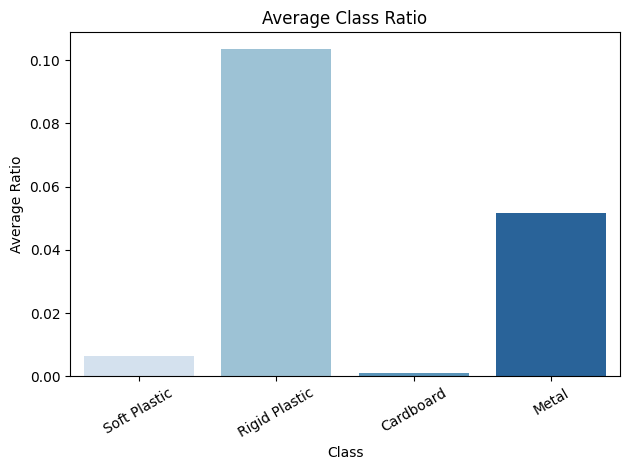

<ipython-input-7-a29c424054bf>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=components_df, x="Class", y="Average Components", palette="Greens")


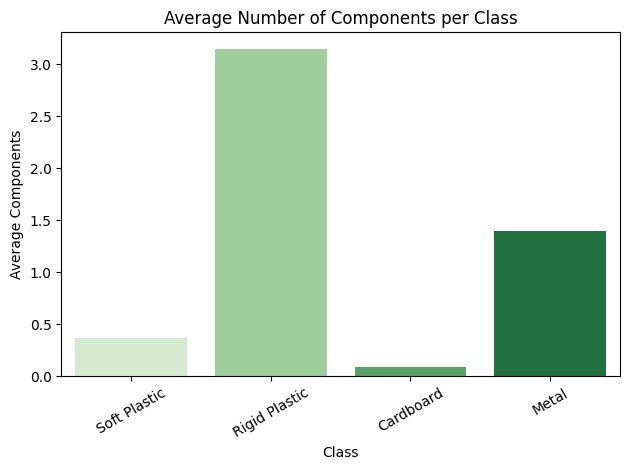

In [7]:
# Visualize class distribution
class_names = {1: "Soft Plastic", 2: "Rigid Plastic", 3: "Cardboard", 4: "Metal"}
classes_to_plot = [1, 2, 3, 4]

# Plot class ratios
ratios = []
for c in classes_to_plot:
    col_name = f'class_{c}_ratio'
    avg_ratio = df[col_name].mean()
    ratios.append({"Class": class_names[c], "Average Ratio": avg_ratio})

ratios_df = pd.DataFrame(ratios)
sns.barplot(data=ratios_df, x="Class", y="Average Ratio", palette="Blues")
plt.title("Average Class Ratio")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

# Plot number of components
components = []
for c in classes_to_plot:
    col_name = f'class_{c}_num_components'
    avg_components = df[col_name].mean()
    components.append({"Class": class_names[c], "Average Components": avg_components})

components_df = pd.DataFrame(components)
sns.barplot(data=components_df, x="Class", y="Average Components", palette="Greens")
plt.title("Average Number of Components per Class")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


<ipython-input-8-5e61b4ea54d0>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=area_df, x="Class", y="Mean Area", palette="Reds")


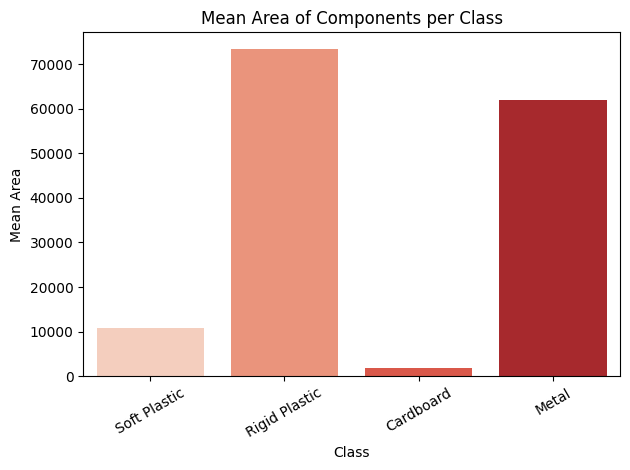

In [8]:
# Plot area statistics for each class
area_stats = []
for c in classes_to_plot:
    col_mean = f'class_{c}_mean_area'
    col_max = f'class_{c}_max_area'
    col_min = f'class_{c}_min_area'
    avg_area = df[col_mean].mean()
    max_area = df[col_max].mean()
    min_area = df[col_min].mean()

    area_stats.append({
        "Class": class_names[c],
        "Mean Area": avg_area,
        "Max Area": max_area,
        "Min Area": min_area
    })

area_df = pd.DataFrame(area_stats)
sns.barplot(data=area_df, x="Class", y="Mean Area", palette="Reds")
plt.title("Mean Area of Components per Class")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


In [10]:
import numpy as np

classes = [1, 2, 3, 4]

presence_count = {}
ratio_sum = {}
component_sum = {}

for c in classes:
    ratio_col = f"class_{c}_ratio"
    comp_col  = f"class_{c}_num_components"

    # How many samples have at least 1 component for class c
    presence_count[c] = (df[comp_col] > 0).sum()

    # Sum of area ratios
    ratio_sum[c] = df[ratio_col].fillna(0).sum()

    # Sum of num_components
    component_sum[c] = df[comp_col].fillna(0).sum()


In [11]:
# You can tune these to emphasize presence vs ratio vs number of components
ALPHA = 1.0  # presence weight
BETA  = 1.0  # ratio weight
GAMMA = 1.0  # component count weight (optional)

weights = []
for i in range(len(df)):
    row = df.iloc[i]
    w = 0.0
    for c in classes:
        ratio_col = f"class_{c}_ratio"
        comp_col  = f"class_{c}_num_components"

        # presence: 1 if num_components>0, else 0
        present_indicator = 1.0 if row[comp_col] > 0 else 0.0

        # ratio
        area_ratio = row[ratio_col] if not np.isnan(row[ratio_col]) else 0.0

        # num_components
        comp_count = row[comp_col] if not np.isnan(row[comp_col]) else 0.0

        # presence term
        if presence_count[c] > 0:
            w += ALPHA * present_indicator * (1.0 / presence_count[c])

        # ratio term
        if ratio_sum[c] > 0:
            w += BETA * area_ratio * (1.0 / ratio_sum[c])

        # component term
        if component_sum[c] > 0:
            w += GAMMA * comp_count * (1.0 / component_sum[c])

    weights.append(w)

df["weight"] = weights


In [15]:
df["weight"] += 0.001 # keep images with no objects

In [16]:
# Save the processed DataFrame
df.to_csv("train_data_analysis.csv", index=False)
print("Data analysis results saved to train_data_analysis.csv")

Data analysis results saved to train_data_analysis.csv
